# Bell-Wigner inequality

_This notebook is an integral part of the paper [Bell inequalities wih Qibo](), where the popular inequalities concerning quantum Bell states are presented for educational purposes._

In the first of this series, we instantiate a quantum circuit with Qibo in order to study the violation of the inequality proposed by Wigner in 1970 to illustrate Bell's findings, which we name Bell-Wigner inequality (cf. paper).

Defining the quantity $Q^W$ as:

$$Q^W = P(\hat{a}+,\hat{b}+) - P(\hat{a}+,\hat{c}+) - P(\hat{c}+,\hat{b}+)$$

In the case of local hidden (LH) variables, the inequality reads:

$$Q^W_{LH} \le 0$$

We will show that in a Qibo quantum circuit the $Q^W$ quantity violates the assumptions of locality as discussed in the paper.

In the [next notebook](https://cernbox.cern.ch/s/T2MhpwcWobCznPF) (temporary link), we turn to the original Bell inequality. 

In [2]:
import time
from math import pi
import qibo
from qibo import Circuit, gates
import matplotlib.pyplot as plt

qibo.set_backend(backend="qibojit")

[Qibo 0.2.7|INFO|2024-06-23 19:18:48]: Using qibojit (numba) backend on /CPU:0


Here we instantiate a circuit with free parameters $\theta$ for the rotations before the measurement. The initial $R_Y$ gates stay with a $\theta = \pi$ rotation in order to convert a $|0\rangle$ initial state to $|1\rangle$ prior to constructing the Bell state.

In [14]:
 c = Circuit(2)
c.add(gates.RY(q=0, theta=pi))
c.add(gates.RY(q=1, theta=pi))
c.add(gates.H(0))
c.add(gates.CNOT(q0=0, q1=1))
c.add(gates.RZ(q=0, theta=0))
c.add(gates.RZ(q=1, theta=0))
c.add(gates.RY(q=0, theta=0))
c.add(gates.RY(q=1, theta=0))
c.add(gates.M(0, 1))
print('%s\n' % c.draw())

q0: ─RY─H─o─RZ─RY─M─
q1: ─RY───X─RZ─RY─M─



Now we define a function to run the simulation for some given values of $\theta_1$ and $\theta_2$. The return value is the probability of the `00` outcome, as this is the only relevant value in order to compute the $Q^W$ quantity.

We also define a number of parameters for the simulation.

In [13]:
def run_circuit_00(th_1, th_2, phi_1, phi_2):
    '''run the simulation for the given choice of theta_1, theta_2, phi_1, and phi_2,
       and return the probability of the "00" outcome'''
    c.set_parameters([pi, pi, phi_1, phi_2, th_1, th_2])
    return c(nshots=nshots).frequencies()['00'] / nshots

# parameters for the simulation
ab_steps = 4
phi_steps = 4
ac_steps = 50
nshots = 20000

Now run the simulation, and note the computation time on different hardware backends.

In [31]:
Q_W = {}
tstart = time.time()   # keep track of the timing: this is not accurate for proper benchmarking, but it's good enough in this context

for i_ab in range(ab_steps+1):
    print('Run for theta_ab = %dpi/%d...' % (i_ab, ab_steps))

    th_ab = pi * i_ab/ab_steps    # theta_ab angles go from 0 to pi inclusive
    P_ab = run_circuit_00(0, th_ab, 0, 0)
    
    Q_W[i_ab] = []

    for i_ac in range(ac_steps+1):
        th_ac = pi * i_ac/ac_steps    # theta_ac angles go from 0 to pi inclusive
        P_ac = run_circuit_00(0, th_ac, 0, 0)
        P_cb = run_circuit_00(th_ac, th_ab, 0, 0)
        Q_W[i_ab].append(P_ab - P_ac - P_cb)

print('Completed in %.1f seconds' % (time.time() - tstart))
# In SWAN, this completes in 29 seconds on a CPU, and 2 seconds on a GPU

Run for theta_ab = 0pi/4...
Run for theta_ab = 1pi/4...
Run for theta_ab = 2pi/4...
Run for theta_ab = 3pi/4...
Run for theta_ab = 4pi/4...
Completed in 33.6 seconds


## Plots

Here we plot the obtained values of $Q^W$ using multiple parametric lines and common `matplotlib` primitives.

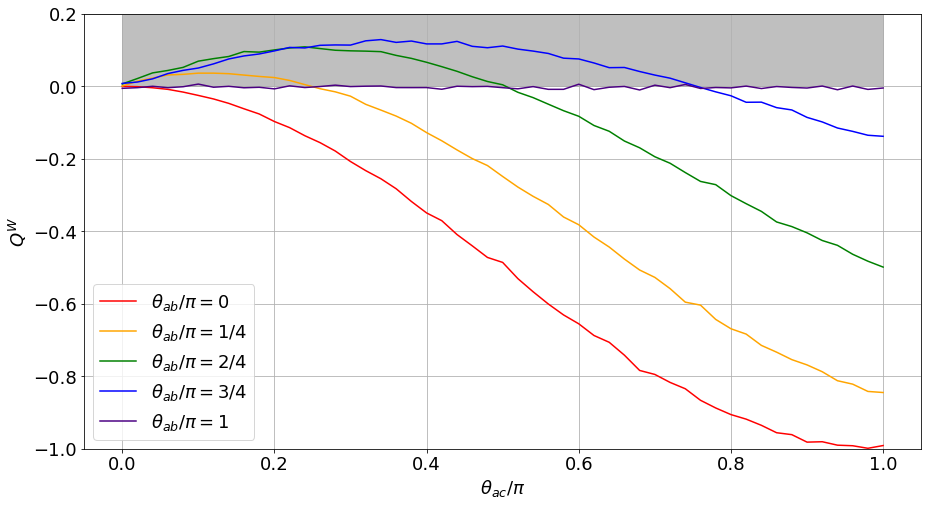

In [35]:
plt.rcParams.update({'font.size': 18})
colors = ["red", "orange", "green", "blue", "indigo"]
fig, ax = plt.subplots(figsize=(15, 8))
th = [(i/ac_steps) for i in range(ac_steps+1)]
labels=['$\\theta_{ab}/\pi = 0$'] + ['$\\theta_{ab}/\pi = %d/%d$' % (i_ab, ab_steps) for i_ab in range(1, ab_steps)] + ['$\\theta_{ab}/\pi = 1$']

for i_ab in range(ab_steps+1):
    ax.plot(th, Q_W[i_ab][:len(th)], color=colors[i_ab], label=labels[i_ab])

# color the violation band
ax.fill_between(x=th, y1=0.2, y2=0, color="0.5", alpha=0.5)
ax.set_ylim([-1, 0.2])
plt.xlabel('$\\theta_{ac} / \pi$')
plt.ylabel('$Q^W$')
plt.grid(True)
plt.legend()
plt.show()
#fig.savefig("simulation_Bell-Wigner_Qibo.pdf")

As an additional exercise, we generate a radial plot: this plot better illustrates the evolution of $Q^W$ when changing $\theta_{ac}$ from 0, which corresponds to $\hat{c}$ aligned with the $z$ axis, conventionally represented as the North direction, to $\pi$, which corresponds to $\hat{c}$ pointing to the South direction.

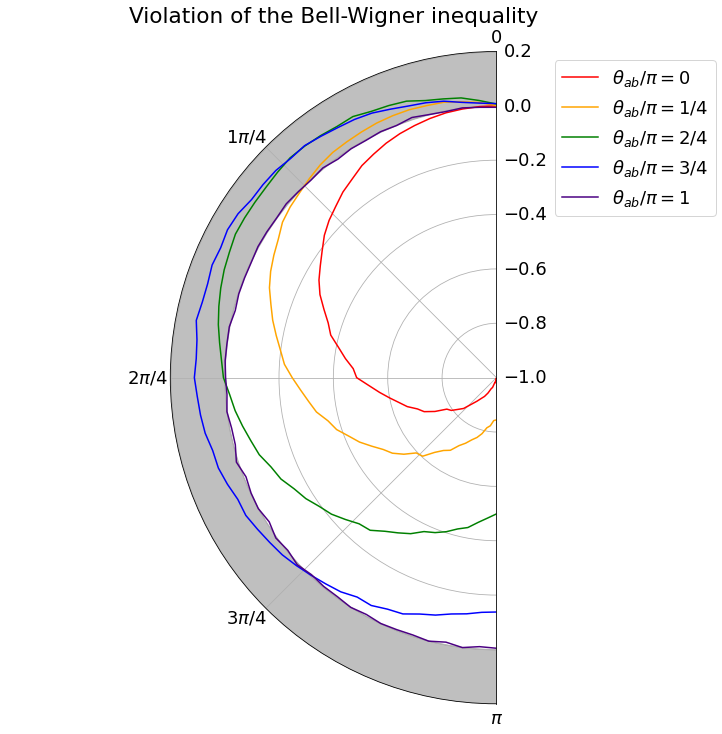

In [33]:
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': 'polar'})
th = [(i*pi/ac_steps) for i in range(ac_steps+1)]

for i_ab in range(ab_steps+1):
    ax.plot(th, Q_W[i_ab][:len(th)], color=colors[i_ab], label=labels[i_ab])

# color the violation band
ax.fill_between(x=th, y1=0.2, y2=0, color="0.5", alpha=0.5)

ax.set_xticks([(i*pi/4) for i in range(5)], labels=['0'] + ['$%d\\pi/4$    ' % i for i in range(1, 4)] + ['$\\pi$'])
ax.set_theta_zero_location("N")
ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_ylim([-1, 0.2])

plt.title('Violation of the Bell-Wigner inequality')
plt.grid(True)
ax.legend(bbox_to_anchor=(1.1, 1.0))
plt.show()
#fig.savefig("simulation_Bell-Wigner_Qibo_polar.pdf")

---

## Rotation around the _z_ axis

This is an alternate simulation, where we rotate around the $z$ axis by the angle $\phi$ and then around the $y$ axis by the angle $\theta_{ab}$. The simulation runs over different values of $\phi$.

In [37]:
Q_W = {}
tstart = time.time()

th_ab = pi/2
P_ab = run_circuit_00(0, th_ab, 0, 0)
for i_phi in range(phi_steps+1):
    print('Run for phi = %dpi/%d...' % (i_phi, phi_steps))

    phi = pi * i_phi/phi_steps    # phi angles go from 0 to pi inclusive
    Q_W[i_phi] = []

    for i_ac in range(ac_steps+1):
        th_ac = pi * i_ac/ac_steps    # theta_ac angles go from 0 to pi inclusive
        P_ac = run_circuit_00(0, th_ac, 0, phi)
        P_cb = run_circuit_00(th_ac, th_ab, phi, 0)
        Q_W[i_phi].append(P_ab - P_ac - P_cb)

print('Completed in %.1f seconds' % (time.time() - tstart))

Run for phi = 0pi/4...
Run for phi = 1pi/4...
Run for phi = 2pi/4...
Run for phi = 3pi/4...
Run for phi = 4pi/4...
Completed in 23.3 seconds


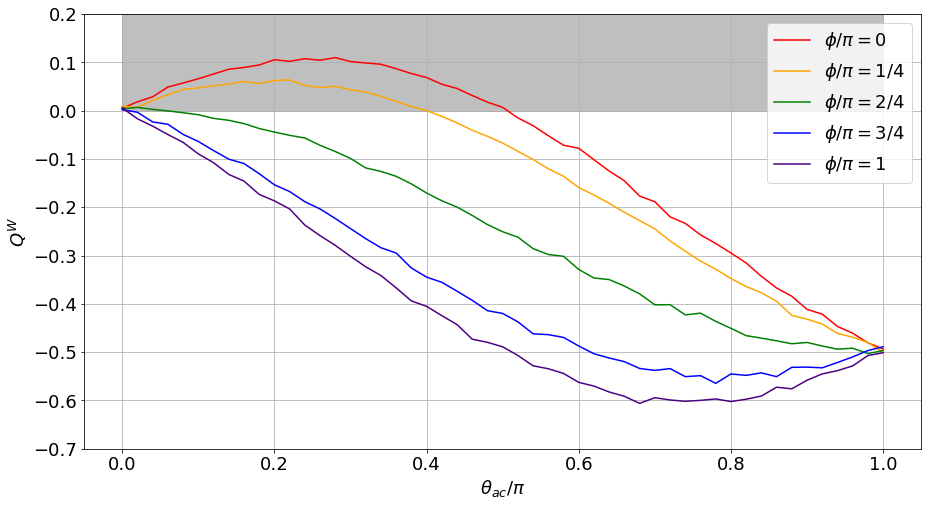

In [45]:
plt.rcParams.update({'font.size': 18})
colors = ["red", "orange", "green", "blue", "indigo"]
fig, ax = plt.subplots(figsize=(15, 8))
th = [(i/ac_steps) for i in range(ac_steps+1)]
labels=['$\phi/\pi = 0$'] + ['$\phi/\pi = %d/%d$' % (i_phi, phi_steps) for i_phi in range(1, phi_steps)] + ['$\phi/\pi = 1$']

for i_phi in range(phi_steps+1):
    ax.plot(th, Q_W[i_phi][:len(th)], color=colors[i_phi], label=labels[i_phi])

# color the violation band
ax.fill_between(x=th, y1=0, y2=0.2, color="0.5", alpha=0.5)
ax.set_ylim([-0.7, 0.2])
plt.xlabel('$\\theta_{ac} / \pi$')
plt.ylabel('$Q^W$')
plt.grid(True)
plt.legend()
plt.show()
#fig.savefig("simulation_Bell-Wigner_Qibo_phi.pdf")